In [15]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, \
average_precision_score
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
model_evaluate_presentation, cross_val_presentation, GridSearchPresentationCV, \
graph_model_history

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

import warnings

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)
tf.keras.backend.set_floatx('float64')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and prepare data
* Load the data for the first half of each course, simulating making predictions at the halfway point.
* Hold out all of the latest data, presentations 2014J of each module
* Use a subset of the training data for validation in model development.
* Holdout data will be used for model selection

In [16]:
df_full = load_OU_data(prediction_window=.5)

df = df_full.drop(columns = ['id_student','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration', 'num_of_prev_attempts'])

df['final_result'] = np.array([1 if w in ['Pass','Distinction'] \
              else 0 for w in df_full['final_result']])

train_df = df[df['code_presentation'] != '2014J']
test_df = df[df['code_presentation'] == '2014J']

X_train = train_df.drop(columns = ['final_result','code_presentation'])
y_train = train_df['final_result']
X_test = test_df.drop(columns = ['final_result','code_presentation'])
y_test = test_df['final_result']

#split 2014J presentations into validation and holdout sets
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size = .2,
                                                     random_state = 111, shuffle=True)

X_train_transformed, y_train_transformed, X_test_transformed \
                                = process_courses(X_train, y_train, X_test)

X_t_transformed, y_t_transformed, X_val_transformed \
                                = process_courses(X_t, y_t, X_val)

PRauc = tf.keras.metrics.AUC(name = 'PRauc', curve = 'PR', thresholds = [.5])


below copied from [Tasos and TQA at Stack Exchange](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)

# First Simple Dense Model

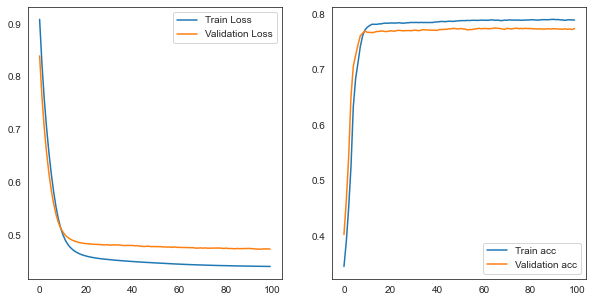

Accuracy on Validation
0.7734546595544399


<AxesSubplot:>

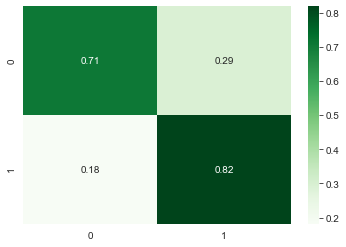

In [17]:
def make_model1():
    model = Sequential()
    model.add(Dense(5, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model1()
modelpath = '../models/densemodel1.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)


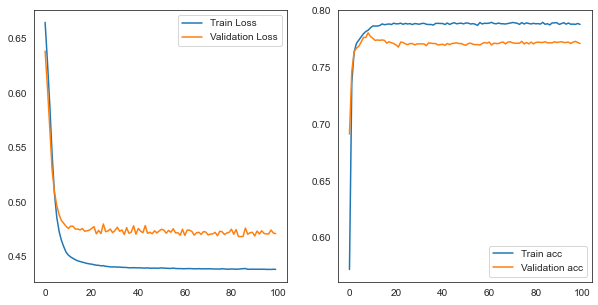

Accuracy on Validation
0.7696893630373391


<AxesSubplot:>

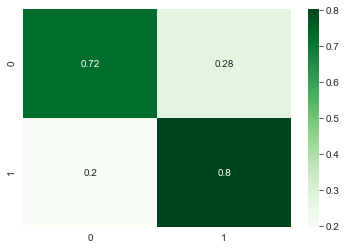

In [18]:
def make_model2():
    model = Sequential()
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model2()
modelpath = '../models/densemodel2.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

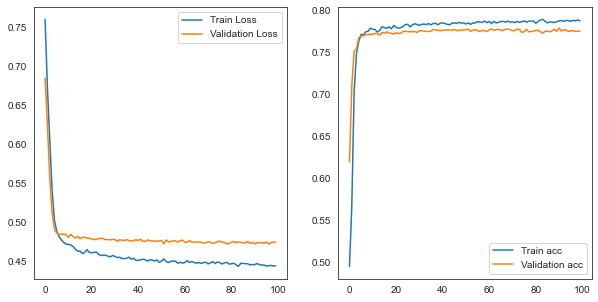

Accuracy on Validation
0.7731408848446815


<AxesSubplot:>

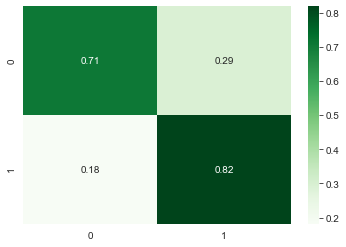

In [19]:
def make_model3():
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate = .1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate = .1))    
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate = .1))

    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model3()
modelpath = '../models/densemodel3.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

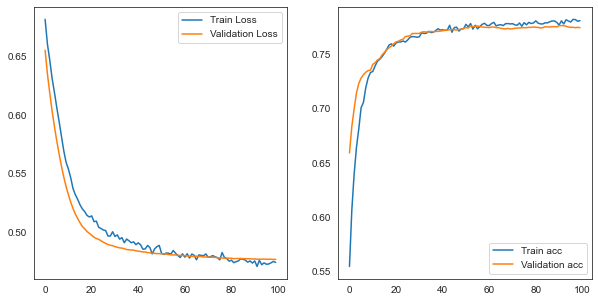

Accuracy on Validation
0.7750235331032319


<AxesSubplot:>

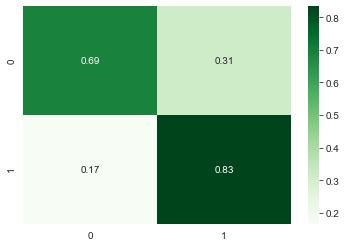

In [20]:
def make_model4():
    model = Sequential()
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))

    model.add(Dense(1, activation='sigmoid'))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=1000,
        decay_rate=0.9)
    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model4()
modelpath = '../models/densemodel4.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

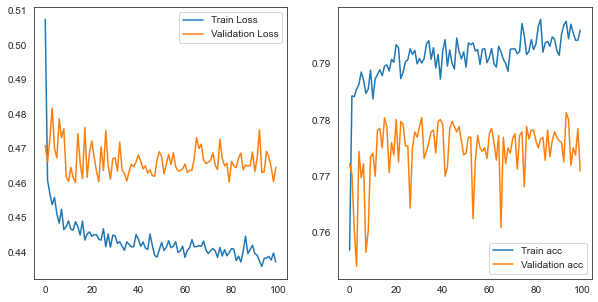

Accuracy on Validation
0.7765924066520239


<AxesSubplot:>

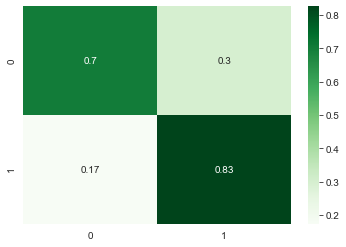

In [21]:
def make_model5():
    model = Sequential()
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(1, activation='sigmoid'))

    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=1000,
        decay_rate=.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model5()
modelpath = '../models/densemodel5.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


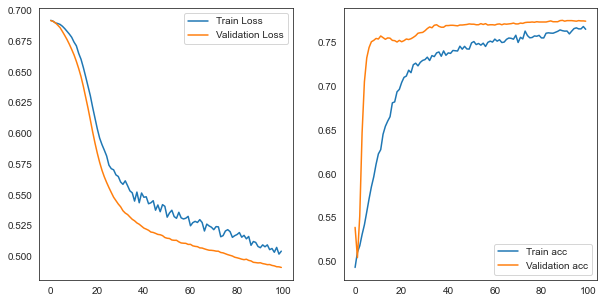

Accuracy on Validation
0.7750235331032319


<AxesSubplot:>

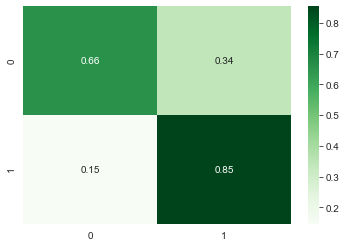

In [22]:
def make_model6():
    model = Sequential()
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(1, activation='sigmoid'))

    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=.9)
    optimizer = optimizers.SGD(
        learning_rate=lr_schedule
    )    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model6()
modelpath = '../models/densemodel6.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

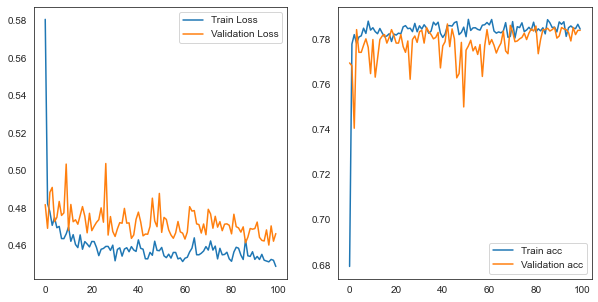

Accuracy on Validation
0.7769061813617822


<AxesSubplot:>

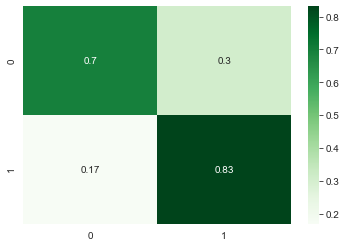

In [23]:
def make_model7():
    model = Sequential()
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(1, activation='sigmoid'))

    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=1000,
        decay_rate=.9)
    optimizer = optimizers.Adam(
        learning_rate=lr_schedule
        )    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model7()
modelpath = '../models/densemodel7.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 100,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

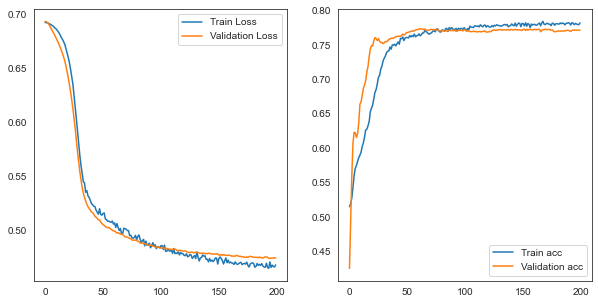

Accuracy on Validation
0.7721995607154063


<AxesSubplot:>

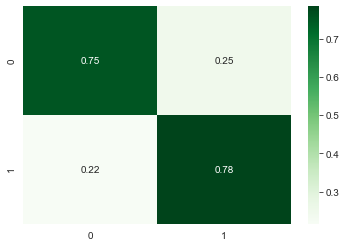

In [24]:
def make_model8():
    model = Sequential()
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=.7)
    optimizer = optimizers.SGD(learning_rate=lr_schedule)    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc', PRauc])

    return model

model = make_model8()
modelpath = '../models/densemodel8.h5'

mc = ModelCheckpoint(filepath=modelpath, save_best_only=True, monitor='acc',
                    mode = 'max')
history = model.fit(X_t_transformed, y_t_transformed,
                  epochs = 200,
                  validation_data = (X_val_transformed, y_val),
                   batch_size = 500,
                   verbose = 0,
                   callbacks = [mc])
model = load_model(modelpath)
y_pred = np.round(model.predict(X_val_transformed))
graph_model_history(history, metric = 'acc')
print('Accuracy on Validation')
print(float(accuracy_score(y_val, y_pred)))
plot_confusion(y_val, y_pred)

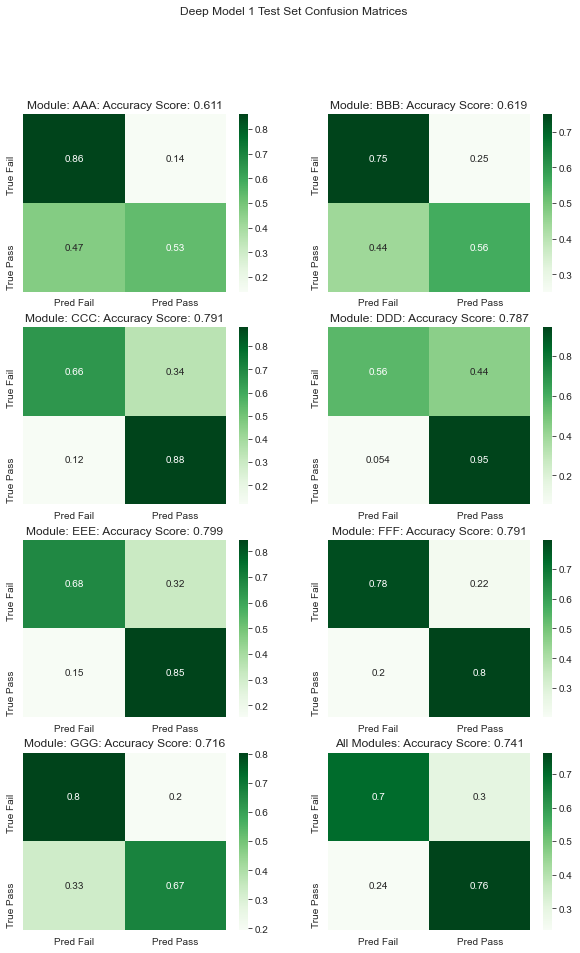

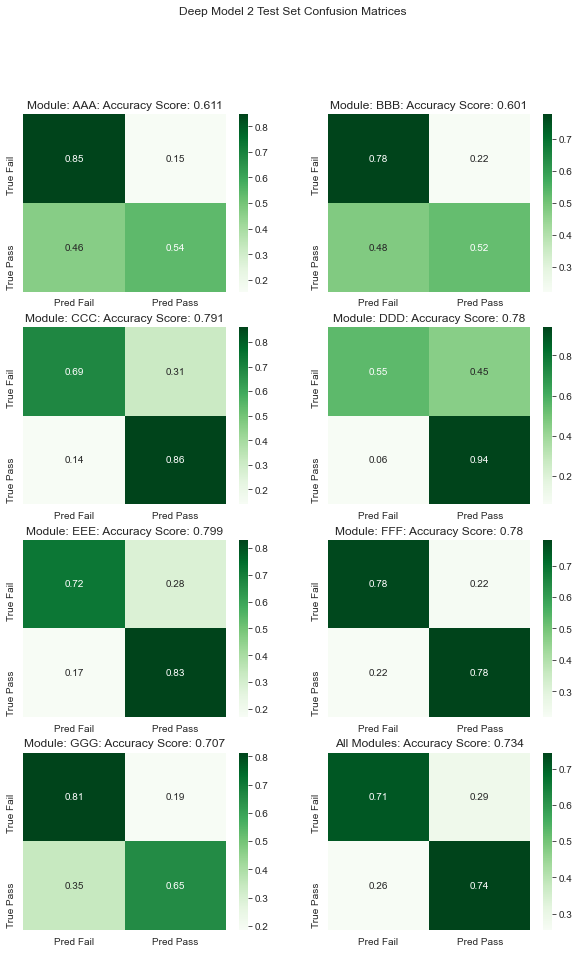

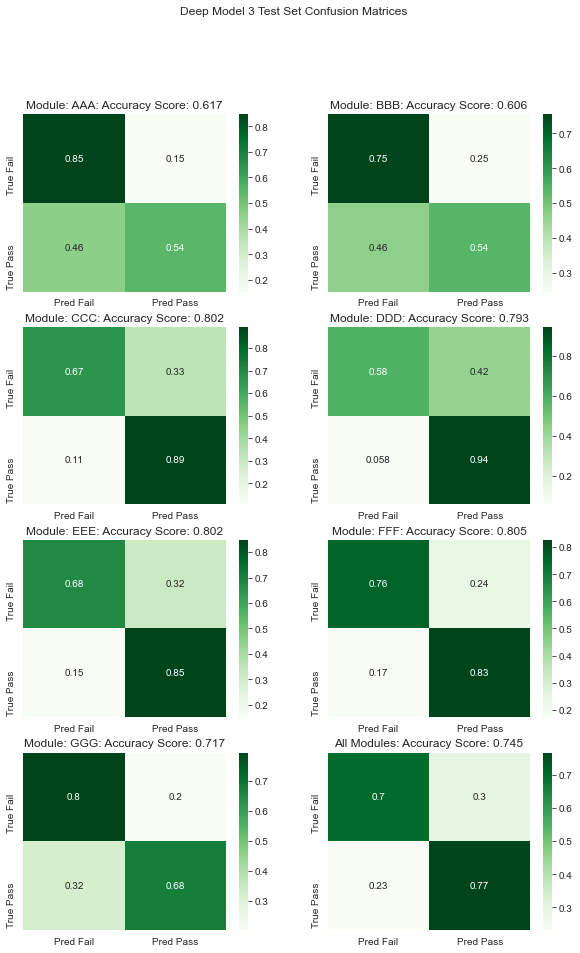

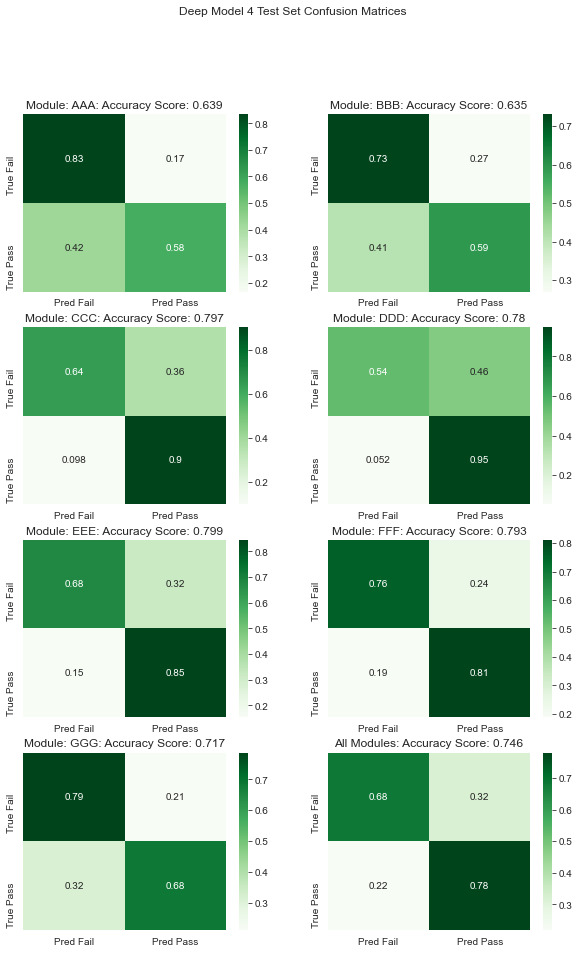

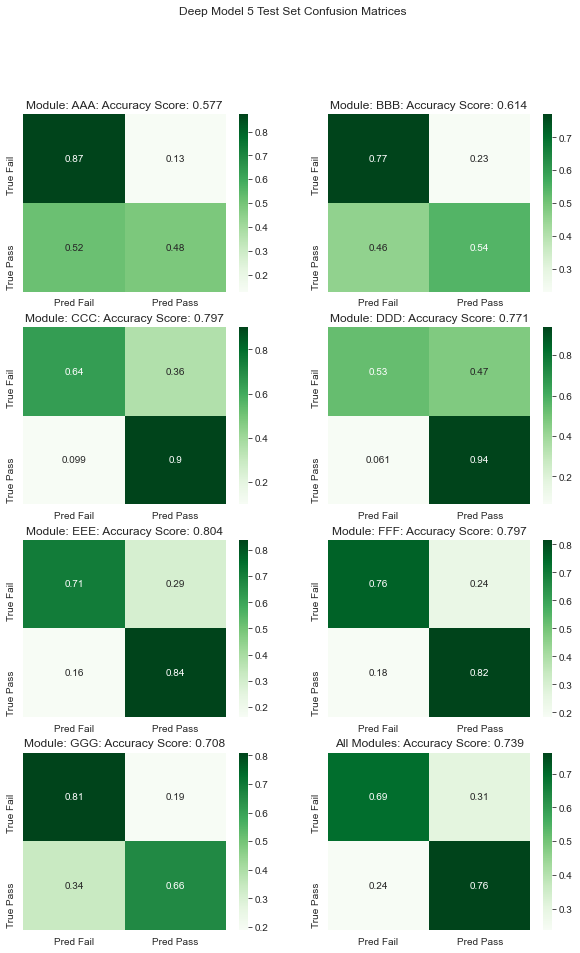

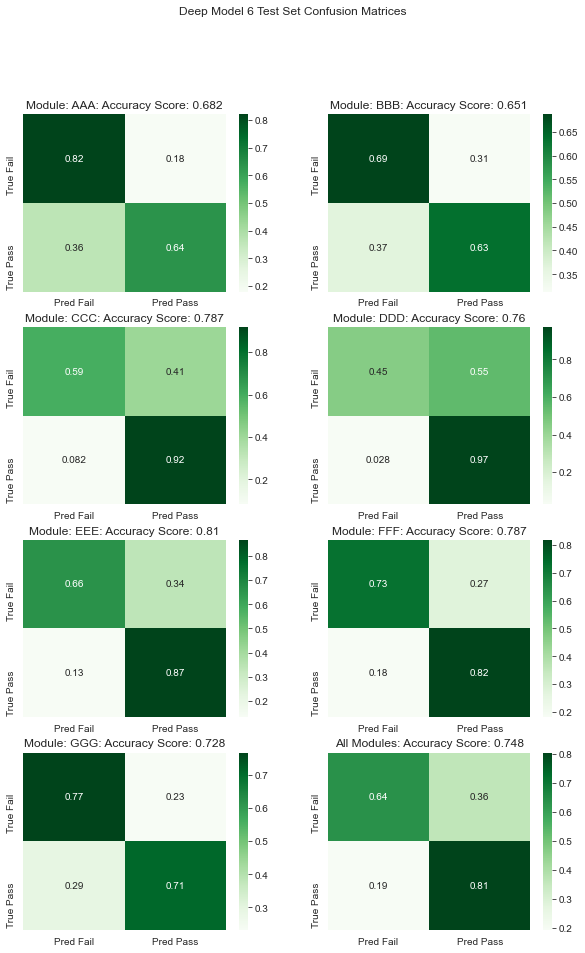

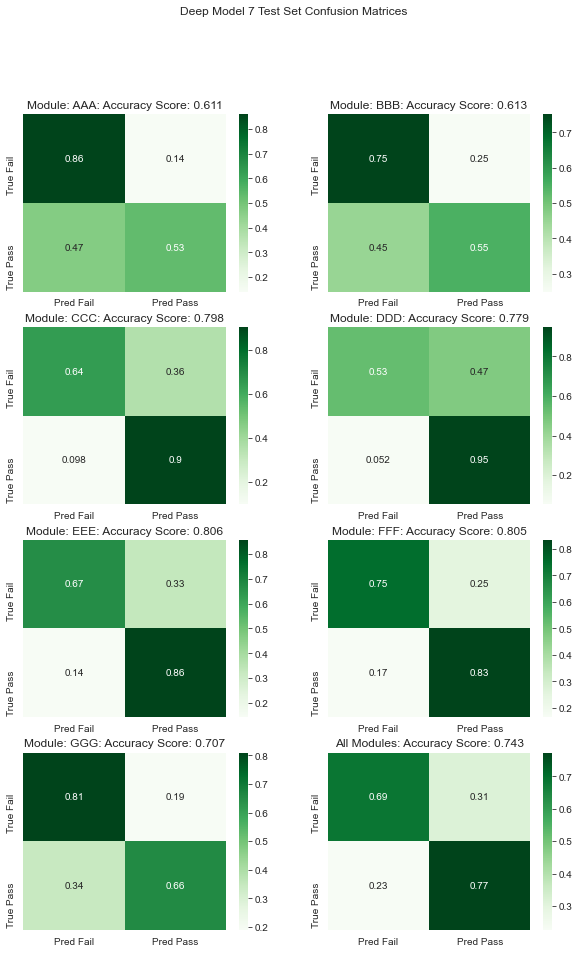

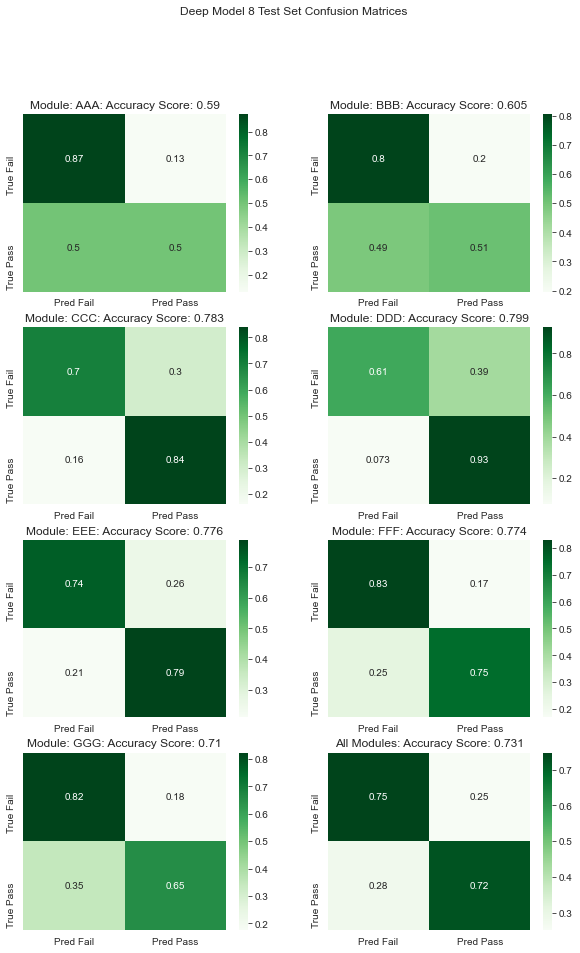

,model 1 accuracy scores,model 2 accuracy scores,model 3 accuracy scores,model 4 accuracy scores,model 5 accuracy scores,model 6 accuracy scores,model 7 accuracy scores,model 8 accuracy scores
AAA,0.611111,0.611111,0.617284,0.638889,0.577160,0.682099,0.611111,0.589506
BBB,0.619104,0.601194,0.605970,0.634627,0.614328,0.651343,0.613134,0.605373
CCC,0.791372,0.791372,0.801674,0.796523,0.796523,0.786864,0.797811,0.783001
DDD,0.786688,0.780273,0.793103,0.780273,0.770650,0.760225,0.778669,0.798717
EEE,0.799335,0.799335,0.801552,0.799335,0.803769,0.810421,0.805987,0.776053
FFF,0.791216,0.779758,0.805220,0.793125,0.796945,0.787397,0.805220,0.774029
GGG,0.715805,0.706687,0.717325,0.717325,0.708207,0.727964,0.706687,0.709726


In [26]:
eval_df = test_df.copy()
modules = eval_df['code_module'].unique()

course_acc = pd.DataFrame(index = modules)

for j in range(1,9):
    model = keras.models.load_model(f'../models/densemodel{j}.h5')
    y_pred = np.round(model.predict(X_test_transformed))
    eval_df[f'model {j} prediction'] = y_pred.astype(int)
    fig, axes = plt.subplots(4,2, figsize = (10,15))
    axes = axes.ravel()
    accuracies = []
    for i, module in enumerate(modules):
        preds = eval_df[eval_df['code_module'] == module][f'model {j} prediction']
        trues = eval_df[eval_df['code_module'] == module]['final_result']
        accuracy = accuracy_score(trues,preds)
        accuracies.append(accuracy)
        plot_confusion(trues,preds, ax = axes[i])
        axes[i].set_title(f'Module: {module}: Accuracy Score: {round(accuracy,3)}')
        axes[i].set_yticklabels(['True Fail', 'True Pass'])
        axes[i].set_xticklabels(['Pred Fail','Pred Pass'])
    course_acc[f'model {j} accuracy scores'] = accuracies
    plot_confusion(y_test, y_pred, ax = axes[-1])
    accuracy = accuracy_score(y_test, y_pred)
    axes[-1].set_title(f'All Modules: Accuracy Score: {round(accuracy,3)}')
    axes[-1].set_yticklabels(['True Fail','True Pass'])
    axes[-1].set_xticklabels(['Pred Fail','Pred Pass'])
    plt.tight_layout(rect = [0,0,0,0])
    plt.suptitle(f'Deep Model {j} Test Set Confusion Matrices')
    plt.show()
display(course_acc)